Requirements

In [ ]:
! pip install tabula-py jpype1 outliers diffprivlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.3 MB/s eta 0:00:00
  Created wheel for outliers: filename=OUTLIERS-0.1-py3-none-any.whl size=1928 sha256=6183b2f6428880c9ac658f4f8c5b3e4a59a54ab928eef2b41f067db781b09458
  Stored in directory: /root/.cache/pip/wheels/df/2d/04/0d2727fab6a5283184a401d555e7061a0daf41a8790ea5c0eb
Successfully built outliers


# 1. Data and EDA


In [ ]:
from google.colab import files

meow = files.upload()

Saving ВНП 24_25 - Вкупно - final.pdf to ВНП 24_25 - Вкупно - final.pdf


In [ ]:
import tabula
import pandas as pd

df = tabula.read_pdf("ВНП 24_25 - Вкупно - final.pdf", pages='all', multiple_tables=False, lattice=True)[0]
df = df.iloc[1:]

df.columns = df.iloc[0]
df = df.iloc[1:]

df.columns = ['Index','Surname','Name','Has_signature','Lab_results','K1','K2','Test_results','Kol','Summarized','Projects_st','Project_np','Summarized2','Summarized3','Grade']
df = df.reset_index()

df = df[['Index','Has_signature','Lab_results','K1','K2','Test_results']]
df = df.dropna()

df['program_code'] = df['Index'].astype(str).str[2]

program_map = {
    '1': 'SIIS',
    '5': 'SIIS',
    '6': 'KN',
    '2': 'SIIS',
    '3': 'PIT'
}

df['program_code'] = df['Index'].astype(str).str[2]

df = df[~df['program_code'].isin(['9', '4'])]

df['study_program'] = df['program_code'].map(program_map)

for code in sorted(df['study_program'].unique()):
    print(f"Code {code}:\n", df[df['study_program'] == code].describe(), "\n")

Code KN:
          Index Has_signature Lab_results  K1  K2 Test_results program_code  \
count       15            15          15  15  15           15           15   
unique      15             1           8  14  12           14            1   
top     226009            ДА        18.0  41  94           49            6   
freq         1            15           4   2   2            2           15   

       study_program  
count             15  
unique             1  
top               KN  
freq              15   

Code PIT:
          Index Has_signature Lab_results   K1   K2 Test_results program_code  \
count      112           112         112  112  112          112          112   
unique     112             1          14   45   51           46            1   
top     223021            ДА        18.0   67   41           64            3   
freq         1           112          33    6    6            6          112   

       study_program  
count            112  
unique             1  
t

In [ ]:
df = df.drop_duplicates(subset='Index',keep='first')
df = df.reset_index(drop=True)
df['K1'] = pd.to_numeric(df['K1'], errors='coerce')
df['K2'] = pd.to_numeric(df['K2'], errors='coerce')
df['Test_results'] = pd.to_numeric(df['Test_results'], errors='coerce')
df['Lab_results'] = pd.to_numeric(df['Lab_results'], errors='coerce')

df.describe()

,Lab_results,K1,K2,Test_results
count,292.000000,292.000000,292.000000,292.000000
mean,15.267808,57.510274,49.671233,53.835616
std,3.348846,13.721452,17.740438,14.114421
min,0.000000,29.000000,10.000000,23.000000
25%,14.000000,47.000000,38.000000,44.000000
50%,16.000000,57.500000,48.000000,53.000000
75%,18.000000,67.000000,60.250000,64.000000
max,20.000000,91.000000,100.000000,96.000000


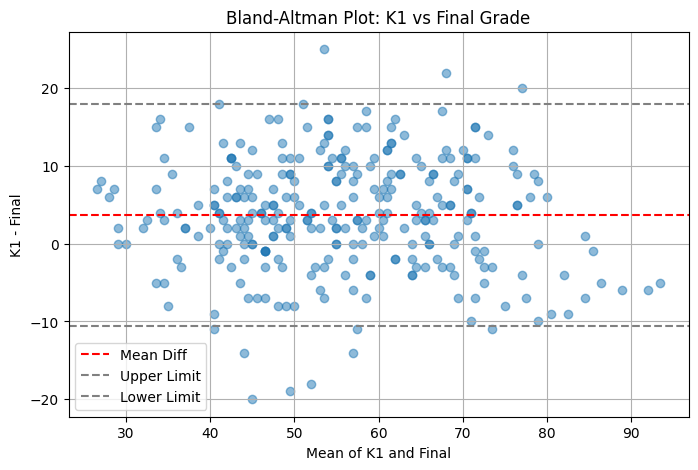

In [ ]:
# The Bland–Altman plot shows that the K1 score slightly overpredicts the final grade on average.
# Most predictions fall within ±20 points. However, the prediction tends to be less stable around mid-performing students,
# suggesting some variability in how well K1 reflects the final outcome.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

x = df["K1"]
y = df["Test_results"]

# Bland–Altman calculations
mean_values = (x + y) / 2
diff_values = x - y
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values, ddof=1)

plt.figure(figsize=(8, 5))
plt.scatter(mean_values, diff_values, alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Diff')
plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='Upper Limit')
plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--', label='Lower Limit')
plt.title('Bland-Altman Plot: K1 vs Final Grade')
plt.xlabel('Mean of K1 and Final')
plt.ylabel('K1 - Final')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(x, y)
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

# There is a systematic bias in mean — K1 scores are consistently higher or lower than the final grades.

Paired t-test: t = 8.593, p = 0.000


In [ ]:
import numpy as np
from scipy.stats import t

def pitman_morgan_test(x, y):
    d = x - y
    s_x = np.std(x, ddof=1)
    s_y = np.std(y, ddof=1)
    r = np.corrcoef(x, y)[0, 1]
    n = len(x)
    T = ((s_x**2 - s_y**2) * np.sqrt(n - 2)) / (
        2 * s_x * s_y * np.sqrt(1 - r**2)
    )
    p_val = 2 * t.sf(np.abs(T), df=n-2)
    return T, p_val

t_stat_pm, p_pm = pitman_morgan_test(x, y)
print(f"Pitman-Morgan test: t = {t_stat_pm:.3f}, p = {p_pm:.3f}")

# The variances of K1 and Final scores are not significantly different.
# So, the consistency/dispersion of the two tests is similar

Pitman-Morgan test: t = -0.950, p = 0.343


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from scipy.stats import f

df_bb = pd.DataFrame({'x': x, 'y': y})
df_bb['mean'] = (df_bb['x'] + df_bb['y']) / 2
df_bb['diff'] = df_bb['x'] - df_bb['y']

model = smf.ols('diff ~ mean', data=df_bb).fit()
ssr = np.sum(model.resid**2)
df_resid = model.df_resid
msr = ssr / df_resid

full_var = np.var(df_bb['diff'], ddof=1)

F = (full_var - msr) / msr
p = f.sf(F, 1, df_resid)
print(f"Bradley-Blackwood test: F = {F:.3f}, p = {p:.3f}")
# There’s no evidence of combined bias (mean + variance).
# Bradley–Blackwood is an omnibus test — it's less sensitive if the variance part dominates, and it's conservative if sample size is large and variances are similar.
# Since Pitman-Morgan showed no variance bias, the Bradley-Blackwood test is likely just ignoring the strong mean bias.

Bradley-Blackwood test: F = -0.000, p = 1.000


In [ ]:
import numpy as np
from scipy.stats import t

def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    # Find the data point furthest from the mean
    max_dev = np.max(np.abs(data - mean))
    G = max_dev / std

    # Critical value
    t_crit = t.ppf(1 - alpha / (2 * n), df=n - 2)
    G_crit = ((n - 1) / np.sqrt(n)) * np.sqrt(t_crit**2 / (n - 2 + t_crit**2))

    is_outlier = G > G_crit
    return G, G_crit, is_outlier

diff = x - y
G, G_crit, outlier = grubbs_test(diff)
print(f"Grubbs' G = {G:.3f}, Critical G = {G_crit:.3f}")
print("Outlier detected?" , "YES" if outlier else "NO")

Grubbs' G = 3.240, Critical G = 3.716
Outlier detected? NO


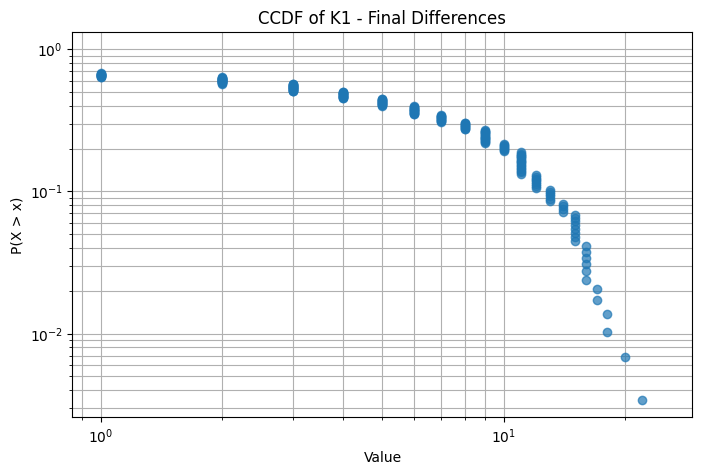

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ccdf(data, label="Data", loglog=True):
    data_sorted = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(data_sorted)+1) / len(data_sorted)

    plt.figure(figsize=(8, 5))
    if loglog:
        plt.loglog(data_sorted, ccdf, marker='o', linestyle='none', alpha=0.7)
    else:
        plt.plot(data_sorted, ccdf, marker='o', linestyle='none', alpha=0.7)

    plt.title(f'CCDF of {label}')
    plt.xlabel('Value')
    plt.ylabel('P(X > x)')
    plt.grid(True, which="both")
    plt.show()

plot_ccdf(diff, label="K1 - Final Differences")

# 2. Trade-Off Curves

In [ ]:
n = len(df)
max_val = df['Test_results'].max()
min_val = df['Test_results'].min()
sensitivity = (max_val - min_val) / n
sensitivity

0.25

In [ ]:
import numpy as np

epsilon = 1.0
true_mean = df['Test_results'].mean()
scale = sensitivity / epsilon
noisy_mean = true_mean + np.random.laplace(0, scale)
print(f'Real mean: {true_mean}')
print(f"Noisy mean: {noisy_mean:.2f}")

Real mean: 53.83561643835616
Noisy mean: 53.85


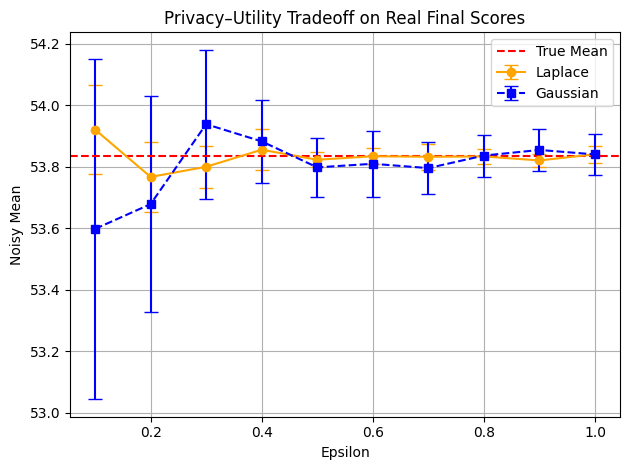

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0.1 + i * 0.1 for i in range(10)]
repeats = 10
delta = 1e-5
final_scores = df['Test_results'].values

laplace_stds = []
gaussian_stds = []

laplace_means = []
gaussian_means = []

np.random.seed(0)

for eps in epsilons:
    # --- Laplace ---
    scale = sensitivity / eps
    lap_runs = []
    for _ in range(repeats):
        noisy = final_scores + np.random.laplace(0, scale, size=len(final_scores))
        noisy = np.clip(noisy, 0, 100)
        lap_runs.append(noisy.mean())
    laplace_means.append(np.mean(lap_runs))
    laplace_stds.append(np.std(lap_runs))

    # --- Gaussian ---
    sigma = (sensitivity / eps) * np.sqrt(2 * np.log(1.25 / delta))
    gauss_runs = []
    for _ in range(repeats):
        noisy = final_scores + np.random.normal(0, sigma, size=len(final_scores))
        noisy = np.clip(noisy, 0, 100)
        gauss_runs.append(noisy.mean())
    gaussian_means.append(np.mean(gauss_runs))
    gaussian_stds.append(np.std(gauss_runs))

true_mean = final_scores.mean()

plt.errorbar(epsilons, laplace_means, yerr=laplace_stds, fmt='o-', capsize=5, label='Laplace', color='orange')
plt.errorbar(epsilons, gaussian_means, yerr=gaussian_stds, fmt='s--', capsize=5, label='Gaussian', color='blue')
plt.axhline(true_mean, color='red', linestyle='--', label='True Mean')

plt.xlabel("Epsilon")
plt.ylabel("Noisy Mean")
plt.title("Privacy–Utility Tradeoff on Real Final Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

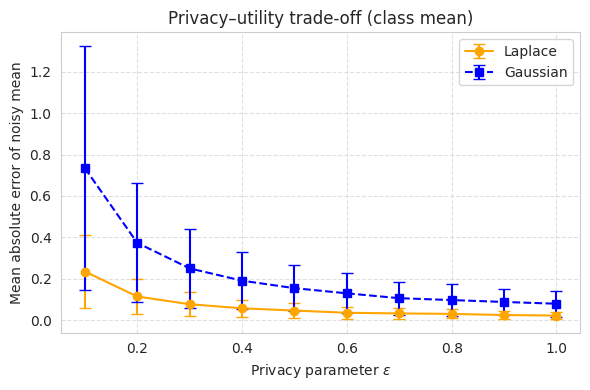

In [ ]:
import numpy as np, matplotlib.pyplot as plt


final_scores = df["Test_results"].to_numpy()
n_students   = len(final_scores)
score_range  = 100
sensitivity  = score_range / n_students

true_mean = final_scores.mean()


epsilons = np.round(np.arange(0.1, 1.05, 0.1), 2)
repeats  = 1_000
delta    = 1e-5
np.random.seed(0)

lap_mae,  lap_sd  = [], []
gau_mae,  gau_sd  = [], []


for eps in epsilons:
    # ---- Laplace ----
    scale = sensitivity / eps
    errs = []
    for _ in range(repeats):
        noisy_mean = (final_scores +
                      np.random.laplace(0, scale, size=n_students)
                     ).clip(0, 100).mean()
        errs.append(abs(noisy_mean - true_mean))
    lap_mae.append(np.mean(errs))
    lap_sd.append(np.std(errs))

    # ---- Gaussian ----
    sigma = (sensitivity / eps) * np.sqrt(2 * np.log(1.25 / delta))
    errs = []
    for _ in range(repeats):
        noisy_mean = (final_scores +
                      np.random.normal(0, sigma, size=n_students)
                     ).clip(0, 100).mean()
        errs.append(abs(noisy_mean - true_mean))
    gau_mae.append(np.mean(errs))
    gau_sd.append(np.std(errs))


plt.figure(figsize=(6,4))

plt.errorbar(epsilons, lap_mae,  yerr=lap_sd,
             fmt='o-',  capsize=4, label='Laplace',  color='orange')
plt.errorbar(epsilons, gau_mae,  yerr=gau_sd,
             fmt='s--', capsize=4, label='Gaussian', color='blue')

plt.xlabel(r"Privacy parameter $\epsilon$")
plt.ylabel("Mean absolute error of noisy mean")
plt.title("Privacy–utility trade-off (class mean)")
plt.grid(ls="--", alpha=.6)
plt.legend()
plt.tight_layout()
plt.show()


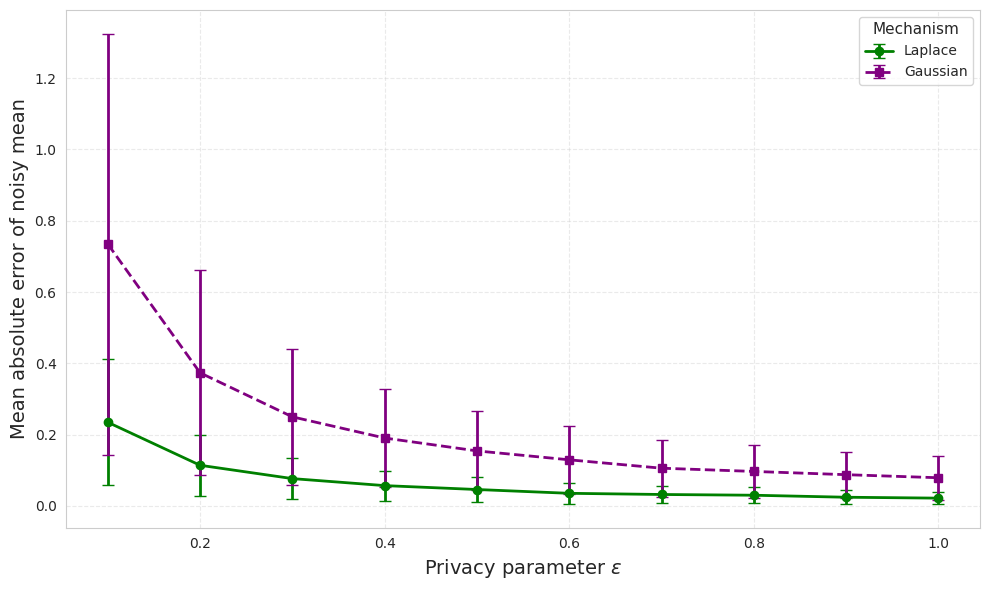

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.errorbar(epsilons, lap_mae, yerr=lap_sd,
             fmt='o-', capsize=4, label='Laplace',
             color='green', linewidth=2, markersize=6)

plt.errorbar(epsilons, gau_mae, yerr=gau_sd,
             fmt='s--', capsize=4, label='Gaussian',
             color='purple', linewidth=2, markersize=6)

plt.xlabel(r"Privacy parameter $\epsilon$", fontsize=14)
plt.ylabel("Mean absolute error of noisy mean", fontsize=14)
plt.title("Privacy–Utility Trade-off for Class Mean", fontsize=16, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=10, title="Mechanism", title_fontsize=11)

plt.tight_layout()
plt.savefig("fig-error-overall-mean.png", dpi=600)
plt.show()


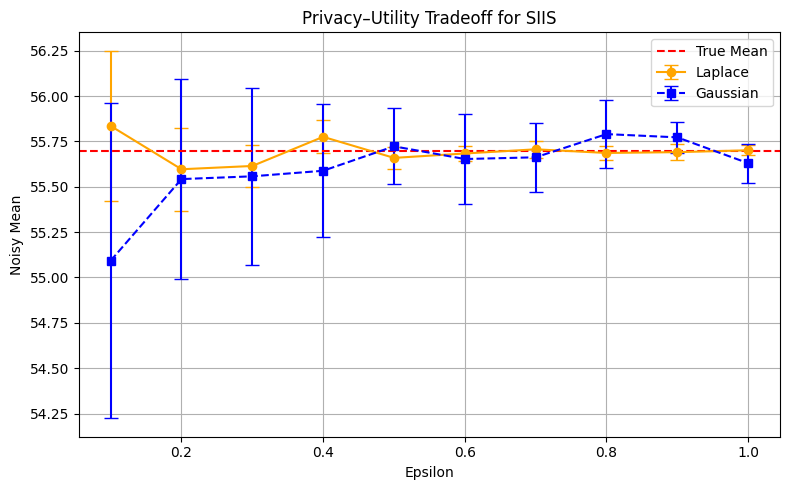

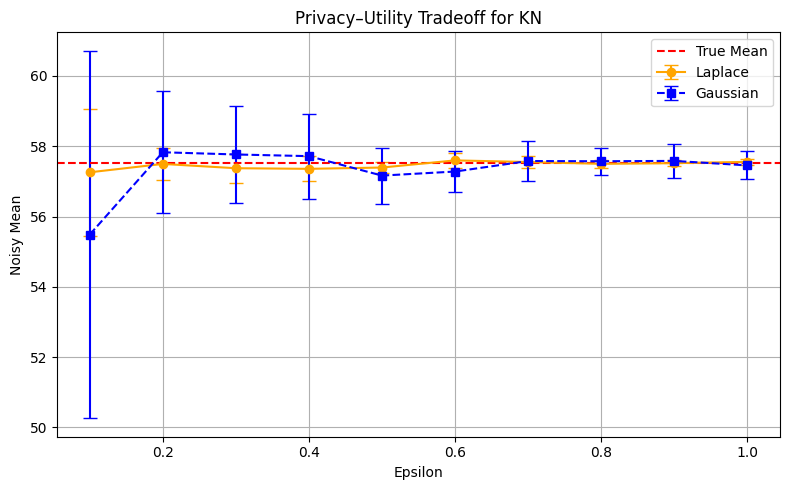

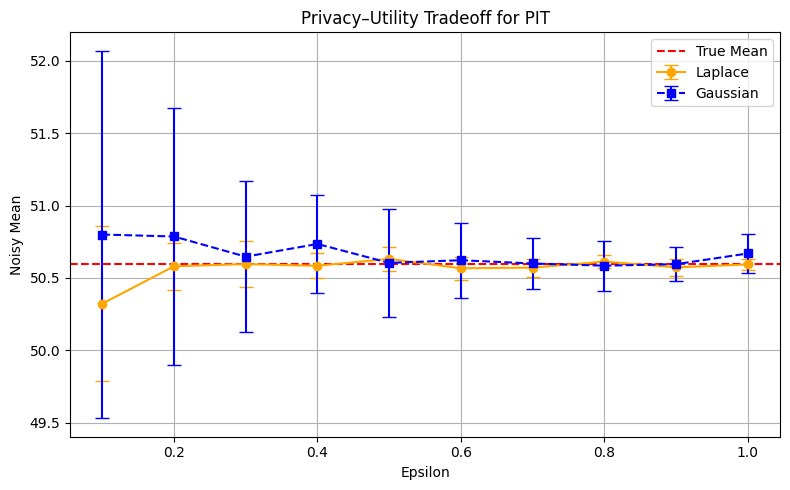

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0.1 + i * 0.1 for i in range(10)]
repeats = 10
delta = 1e-5

study_groups = ['SIIS', 'KN', 'PIT']
group_results = {group: {'laplace_means': [], 'laplace_stds': [],
                         'gaussian_means': [], 'gaussian_stds': [],
                         'true_mean': df[df['study_program'] == group]['Test_results'].mean()}
                 for group in study_groups}

np.random.seed(0)

for eps in epsilons:
    for group in study_groups:
        scores = df[df['study_program'] == group]['Test_results'].values

        # Laplace
        lap_means = []
        scale = sensitivity / eps
        for _ in range(repeats):
            noisy = scores + np.random.laplace(0, scale, size=len(scores))
            noisy = np.clip(noisy, 0, 100)
            lap_means.append(np.mean(noisy))
        group_results[group]['laplace_means'].append(np.mean(lap_means))
        group_results[group]['laplace_stds'].append(np.std(lap_means))

        # Gaussian
        gauss_means = []
        sigma = (sensitivity / eps) * np.sqrt(2 * np.log(1.25 / delta))
        for _ in range(repeats):
            noisy = scores + np.random.normal(0, sigma, size=len(scores))
            noisy = np.clip(noisy, 0, 100)
            gauss_means.append(np.mean(noisy))
        group_results[group]['gaussian_means'].append(np.mean(gauss_means))
        group_results[group]['gaussian_stds'].append(np.std(gauss_means))


for group in study_groups:
    plt.figure(figsize=(8, 5))
    plt.errorbar(epsilons, group_results[group]['laplace_means'],
                 yerr=group_results[group]['laplace_stds'], fmt='o-', label='Laplace', color='orange', capsize=5)

    plt.errorbar(epsilons, group_results[group]['gaussian_means'],
                 yerr=group_results[group]['gaussian_stds'], fmt='s--', label='Gaussian', color='blue', capsize=5)

    plt.axhline(group_results[group]['true_mean'], color='red', linestyle='--', label='True Mean')

    plt.title(f"Privacy–Utility Tradeoff for {group}")
    plt.xlabel("Epsilon")
    plt.ylabel("Noisy Mean")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

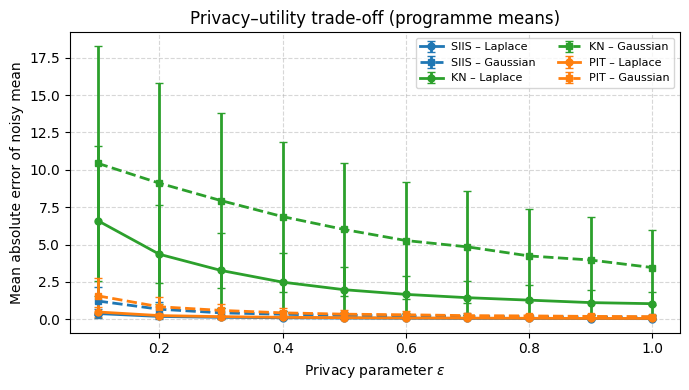

In [ ]:
import numpy as np, matplotlib.pyplot as plt

epsilons = np.round(np.arange(0.1, 1.05, 0.1), 2)
repeats  = 1000
delta    = 1e-5
programs = ["SIIS", "KN", "PIT"]
colour   = {"SIIS":"#1f77b4", "KN":"#2ca02c", "PIT":"#ff7f0e"}

rows = []
np.random.seed(0)

for prog in programs:
    scores = df.loc[df.study_program == prog, "Test_results"].to_numpy()
    n      = len(scores)
    true_m = scores.mean()

    score_range = scores.max() - scores.min()
    sens        = score_range / n

    for eps in epsilons:
        # ---------- Laplace ----------
        scale = sens / eps
        lap_errs = [
            abs(((scores + np.random.laplace(0, scale, n))
                 .clip(0, 100)).mean() - true_m)
            for _ in range(repeats)
        ]
        rows.append({"Prog": prog, "ε": eps, "Mech": "Laplace",
                     "err_mean": np.mean(lap_errs),
                     "err_sd":   np.std(lap_errs)})

        # ---------- Gaussian ----------
        sigma = (sens / eps) * np.sqrt(2 * np.log(1.25 / delta))
        gau_errs = [
            abs(((scores + np.random.normal(0, sigma, n))
                 .clip(0, 100)).mean() - true_m)
            for _ in range(repeats)
        ]
        rows.append({"Prog": prog, "ε": eps, "Mech": "Gaussian",
                     "err_mean": np.mean(gau_errs),
                     "err_sd":   np.std(gau_errs)})

plt.figure(figsize=(7, 4))

for prog in programs:
    sub = [r for r in rows if r["Prog"] == prog]
    for mech, lstyle, marker in [("Laplace", "-", "o"),
                                 ("Gaussian", "--", "s")]:
        eps  = [r["ε"]        for r in sub if r["Mech"] == mech]
        mu   = [r["err_mean"] for r in sub if r["Mech"] == mech]
        sd   = [r["err_sd"]   for r in sub if r["Mech"] == mech]

        plt.errorbar(eps, mu, yerr=sd,
                     linestyle=lstyle, marker=marker,
                     color=colour[prog],
                     label=f"{prog} – {mech}",
                     capsize=3, linewidth=2, markersize=5)

plt.xlabel(r"Privacy parameter $\epsilon$")
plt.ylabel("Mean absolute error of noisy mean")
plt.title("Privacy–utility trade-off (programme means)")
plt.grid(ls="--", alpha=.5)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


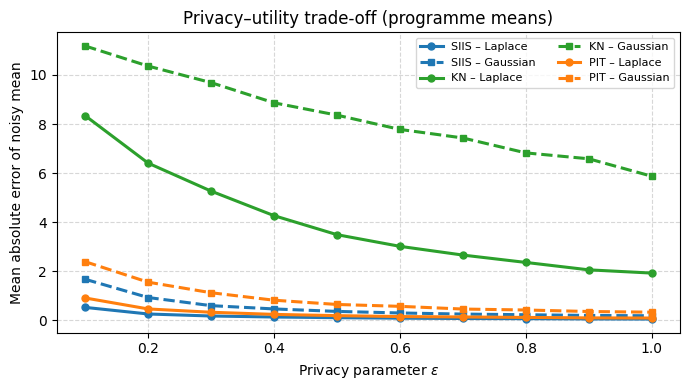

In [ ]:
import numpy as np, matplotlib.pyplot as plt

epsilons = np.round(np.arange(0.1, 1.05, 0.1), 2)
repeats  = 1000
delta    = 1e-5
programs = ["SIIS", "KN", "PIT"]

colour = {"SIIS":"#1f77b4", "KN":"#2ca02c", "PIT":"#ff7f0e"}
style  = {"Laplace":("-", "o"), "Gaussian":("--", "s")}

rows = []
np.random.seed(0)

for prog in programs:
    scores = df.loc[df.study_program == prog, "Test_results"].to_numpy()
    n      = len(scores)
    true_m = scores.mean()
    sens   = 100 / n

    for eps in epsilons:
        # Laplace
        scale = sens / eps
        lap_err = np.mean([
            abs(((scores + np.random.laplace(0, scale, n)).clip(0,100)).mean()
                - true_m)
            for _ in range(repeats)
        ])
        rows.append({"Prog":prog, "ε":eps, "Mech":"Laplace", "err":lap_err})

        # Gaussian
        sigma = sens / eps * np.sqrt(2*np.log(1.25/delta))
        gau_err = np.mean([
            abs(((scores + np.random.normal(0, sigma, n)).clip(0,100)).mean()
                - true_m)
            for _ in range(repeats)
        ])
        rows.append({"Prog":prog, "ε":eps, "Mech":"Gaussian", "err":gau_err})

plt.figure(figsize=(7,4))

for prog in programs:
    sub = [r for r in rows if r["Prog"] == prog]
    for mech in ["Laplace", "Gaussian"]:
        ls, mk = style[mech]
        eps  = [r["ε"]  for r in sub if r["Mech"] == mech]
        err  = [r["err"] for r in sub if r["Mech"] == mech]
        plt.plot(eps, err, ls, marker=mk,
                 color=colour[prog], linewidth=2.2, markersize=5,
                 label=f"{prog} – {mech}")

plt.xlabel(r"Privacy parameter $\epsilon$")
plt.ylabel("Mean absolute error of noisy mean")
plt.title("Privacy–utility trade-off (programme means)")
plt.grid(ls="--", alpha=.5)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


# 3. Distribution Estimation

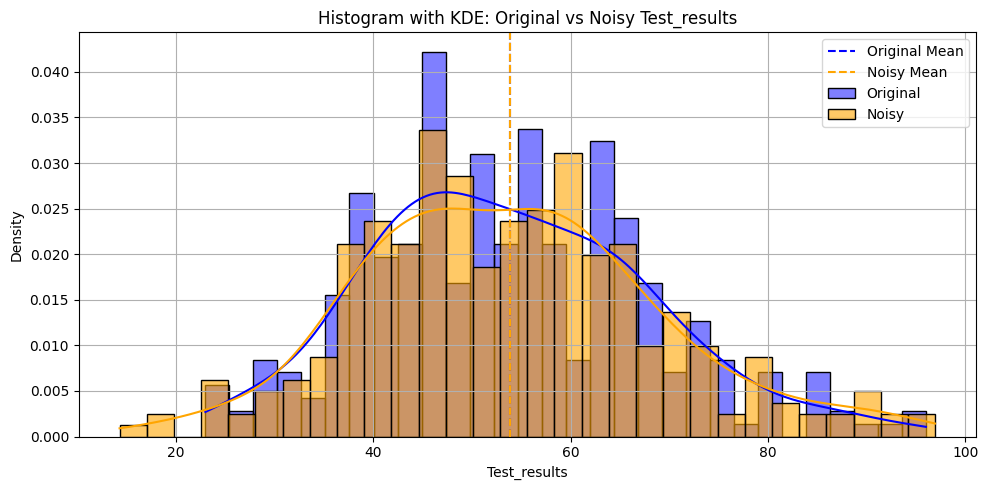

In [ ]:
import numpy as np
noisy_df2 = df.copy()

epsilon = 0.1
scale = sensitivity / epsilon

np.random.seed(0)
noisy_df2['Test_results'] = noisy_df2['Test_results'] + np.random.laplace(0, scale, size=len(noisy_df2))
noisy_df2['Test_results'] = noisy_df2['Test_results'].clip(lower=0, upper=100)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['Test_results'], bins=30, kde=True, color='blue', label='Original', stat='density')
sns.histplot(noisy_df2['Test_results'], bins=30, kde=True, color='orange', label='Noisy', stat='density', alpha=0.6)
plt.axvline(df['Test_results'].mean(), color='blue', linestyle='--', label='Original Mean')
plt.axvline(noisy_df2['Test_results'].mean(), color='orange', linestyle='--', label='Noisy Mean')
plt.title("Histogram with KDE: Original vs Noisy Test_results")
plt.xlabel("Test_results")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
orig_std = df['Test_results'].std()
noisy_std = noisy_df2['Test_results'].std()
std_change = noisy_std - orig_std
std_ratio = noisy_std / orig_std

print(f"Original STD: {orig_std:.2f}")
print(f"Noisy STD:    {noisy_std:.2f}")
print(f"STD Change:   {std_change:.2f}")
print(f"STD Ratio:    {std_ratio:.2f}x")

Original STD: 14.11
Noisy STD:    14.96
STD Change:   0.85
STD Ratio:    1.06x


In [ ]:
study_groups = df['study_program'].unique()

for group in study_groups:
    orig = df[df['study_program'] == group]['Test_results']
    noisy = noisy_df2[noisy_df2['study_program'] == group]['Test_results']

    orig_std = orig.std()
    noisy_std = noisy.std()
    std_change = noisy_std - orig_std
    std_ratio = noisy_std / orig_std if orig_std > 0 else np.nan

    print(f"{group}")
    print(f"  Original STD: {orig_std:.2f}")
    print(f"  Noisy STD:    {noisy_std:.2f}")
    print(f"  STD Change:   {std_change:.2f}")
    print(f"  STD Ratio:    {std_ratio:.2f}x\n")


SIIS
  Original STD: 15.01
  Noisy STD:    15.87
  STD Change:   0.86
  STD Ratio:    1.06x

KN
  Original STD: 15.22
  Noisy STD:    16.11
  STD Change:   0.89
  STD Ratio:    1.06x

PIT
  Original STD: 11.95
  Noisy STD:    12.40
  STD Change:   0.45
  STD Ratio:    1.04x



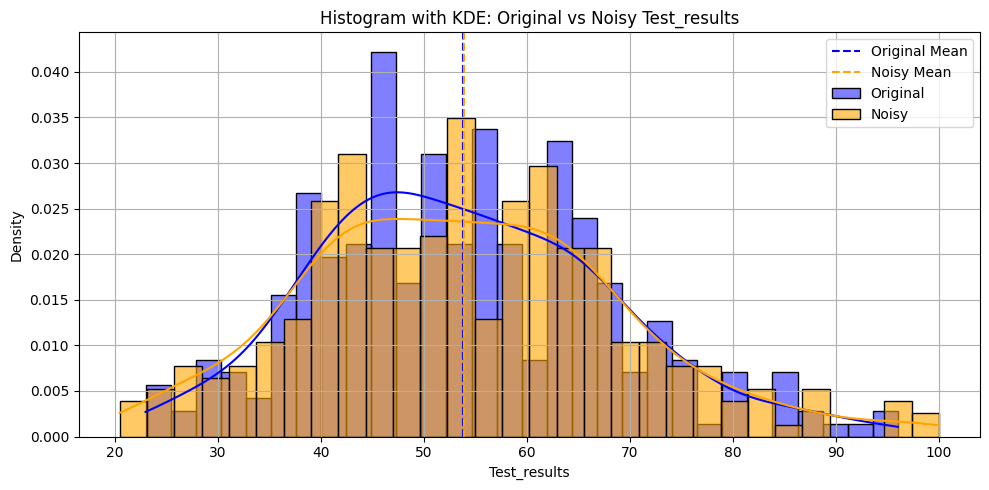

In [ ]:
import numpy as np

noisy_df = df.copy()

epsilon = 0.4
delta = 1e-5

sigma = (sensitivity / epsilon) * np.sqrt(2 * np.log(1.25 / delta))

np.random.seed(0)
noisy_df['Test_results'] = df['Test_results'] + np.random.normal(0, sigma, size=len(df))
noisy_df['Test_results'] = noisy_df['Test_results'].clip(lower=0, upper=100)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['Test_results'], bins=30, kde=True, color='blue', label='Original', stat='density')
sns.histplot(noisy_df['Test_results'], bins=30, kde=True, color='orange', label='Noisy', stat='density', alpha=0.6)
plt.axvline(df['Test_results'].mean(), color='blue', linestyle='--', label='Original Mean')
plt.axvline(noisy_df['Test_results'].mean(), color='orange', linestyle='--', label='Noisy Mean')
plt.title("Histogram with KDE: Original vs Noisy Test_results")
plt.xlabel("Test_results")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
orig_std = df['Test_results'].std()
noisy_std = noisy_df['Test_results'].std()
std_change = noisy_std - orig_std
std_ratio = noisy_std / orig_std

print(f"Original STD: {orig_std:.2f}")
print(f"Noisy STD:    {noisy_std:.2f}")
print(f"STD Change:   {std_change:.2f}")
print(f"STD Ratio:    {std_ratio:.2f}x")

Original STD: 14.11
Noisy STD:    15.23
STD Change:   1.12
STD Ratio:    1.08x


In [ ]:
study_groups = df['study_program'].unique()

for group in study_groups:
    orig = df[df['study_program'] == group]['Test_results']
    noisy = noisy_df[noisy_df['study_program'] == group]['Test_results']

    orig_std = orig.std()
    noisy_std = noisy.std()
    std_change = noisy_std - orig_std
    std_ratio = noisy_std / orig_std if orig_std > 0 else np.nan

    print(f"{group}")
    print(f"  Original STD: {orig_std:.2f}")
    print(f"  Noisy STD:    {noisy_std:.2f}")
    print(f"  STD Change:   {std_change:.2f}")
    print(f"  STD Ratio:    {std_ratio:.2f}x\n")


SIIS
  Original STD: 15.01
  Noisy STD:    16.00
  STD Change:   0.99
  STD Ratio:    1.07x

KN
  Original STD: 15.22
  Noisy STD:    17.37
  STD Change:   2.15
  STD Ratio:    1.14x

PIT
  Original STD: 11.95
  Noisy STD:    12.97
  STD Change:   1.02
  STD Ratio:    1.09x



,Distribution,AIC,BIC,AICc,LogLikelihood
0,Normal,2377.621446,2384.974954,2377.662969,-1186.810723
2,Logistic,2383.732841,2391.086349,2383.774363,-1189.866420
1,Laplace,2412.130336,2419.483843,2412.171858,-1204.065168


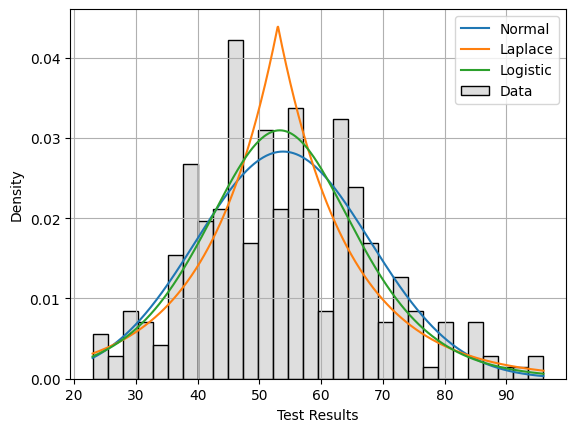

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats


def compute_criteria(data, dist, name):
    params = dist.fit(data)
    log_likelihood = np.sum(dist.logpdf(data, *params))
    k = len(params)
    n = len(data)

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n - k - 1 > 0 else np.nan

    return {
        'Distribution': name,
        'AIC': aic,
        'BIC': bic,
        'AICc': aicc,
        'LogLikelihood': log_likelihood
    }

data = df['Test_results'].dropna().values
distributions = [
    (stats.norm, "Normal"),
    (stats.laplace, "Laplace"),
    (stats.logistic, "Logistic"),
]

results = [compute_criteria(data, dist, name) for dist, name in distributions]
results_df = pd.DataFrame(results).sort_values("AIC")

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import IPython.display as dp
dp.display(pd.DataFrame(results_df))

x = np.linspace(data.min(), data.max(), 1000)
sns.histplot(data, kde=False, stat='density', bins=30, color='lightgray', label='Data')

for dist, name in distributions:
    params = dist.fit(data)
    plt.plot(x, dist.pdf(x, *params), label=name)

plt.legend()
plt.xlabel("Test Results")
plt.ylabel("Density")
plt.grid(True)
plt.show()

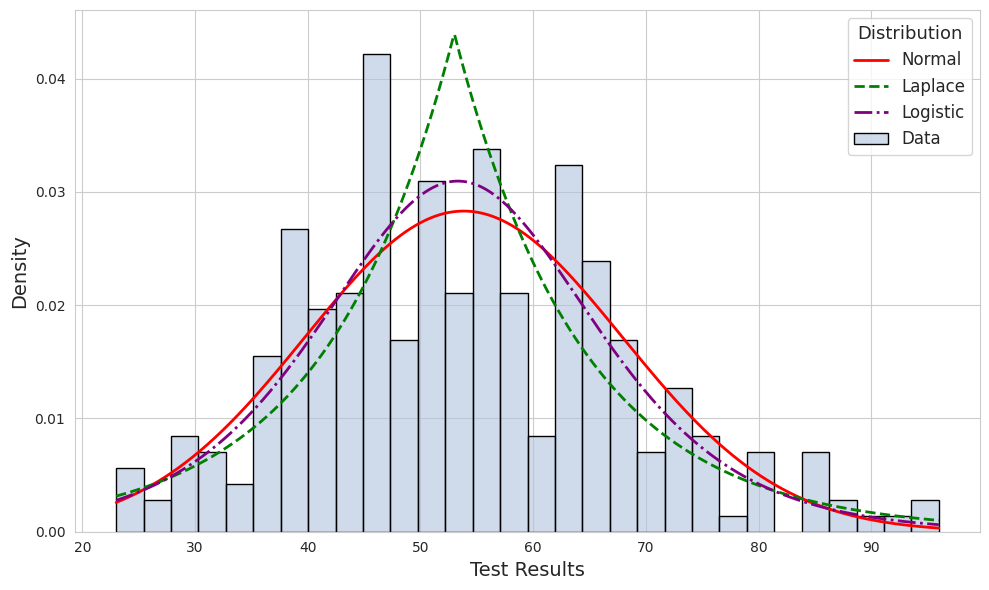

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(data, kde=False, stat='density', bins=30, color='lightsteelblue', edgecolor='black', alpha=0.6, label='Data')

colors = {'Normal': 'red', 'Laplace': 'green', 'Logistic': 'purple'}
linestyles = {'Normal': '-', 'Laplace': '--', 'Logistic': '-.'}

x = np.linspace(data.min(), data.max(), 1000)
for dist, name in distributions:
    params = dist.fit(data)
    plt.plot(x, dist.pdf(x, *params), label=name, color=colors[name], linestyle=linestyles[name], linewidth=2)

plt.xlabel("Test Results", fontsize=14)
plt.ylabel("Density", fontsize=14)

plt.legend(title='Distribution', fontsize=12, title_fontsize=13, loc='best')

plt.tight_layout()
plt.savefig("fig-distribution-fit.png", dpi=600)

plt.show()

,Distribution,AIC,BIC,AICc,LogLikelihood
0,Normal,2422.132943,2429.486450,2422.174465,-1209.066471
2,Logistic,2425.740406,2433.093914,2425.781929,-1210.870203
1,Laplace,2449.504374,2456.857882,2449.545897,-1222.752187


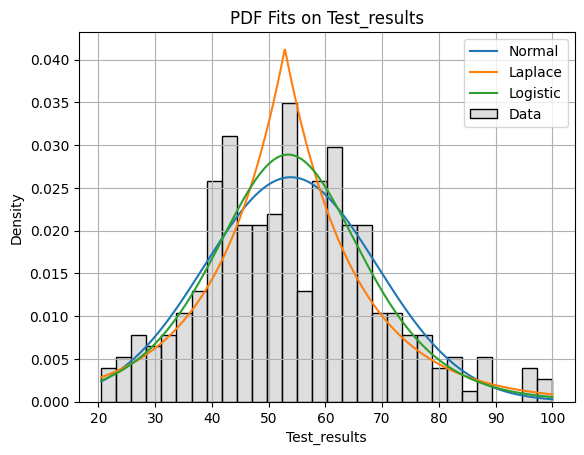

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats


def compute_criteria(data, dist, name):
    params = dist.fit(data)
    log_likelihood = np.sum(dist.logpdf(data, *params))
    k = len(params)
    n = len(data)

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n - k - 1 > 0 else np.nan

    return {
        'Distribution': name,
        'AIC': aic,
        'BIC': bic,
        'AICc': aicc,
        'LogLikelihood': log_likelihood
    }

data = noisy_df['Test_results'].dropna().values
distributions = [
    (stats.norm, "Normal"),
    (stats.laplace, "Laplace"),
    (stats.logistic, "Logistic"),
]

results = [compute_criteria(data, dist, name) for dist, name in distributions]
results_df = pd.DataFrame(results).sort_values("AIC")

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import IPython.display as dp
dp.display(pd.DataFrame(results_df))

x = np.linspace(data.min(), data.max(), 1000)
sns.histplot(data, kde=False, stat='density', bins=30, color='lightgray', label='Data')

for dist, name in distributions:
    params = dist.fit(data)
    plt.plot(x, dist.pdf(x, *params), label=name)

plt.legend()
plt.title("PDF Fits on Test_results")
plt.xlabel("Test_results")
plt.ylabel("Density")
plt.grid(True)
plt.show()

,Distribution,AIC,BIC,AICc,LogLikelihood
0,Normal,2411.710943,2419.064451,2411.752466,-1203.855472
2,Logistic,2413.220970,2420.574477,2413.262492,-1204.610485
1,Laplace,2438.001776,2445.355284,2438.043299,-1217.000888


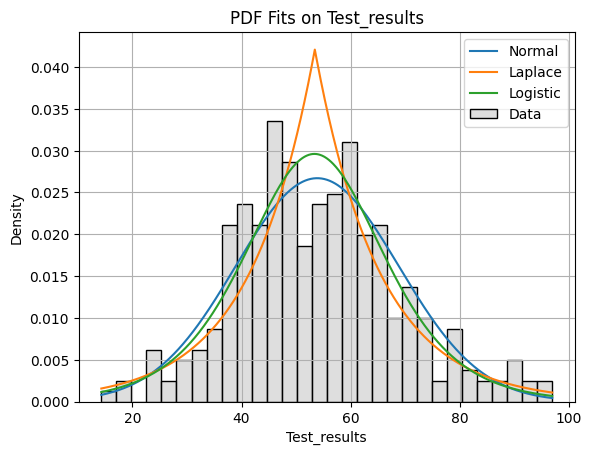

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats


def compute_criteria(data, dist, name):
    params = dist.fit(data)
    log_likelihood = np.sum(dist.logpdf(data, *params))
    k = len(params)
    n = len(data)

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n - k - 1 > 0 else np.nan

    return {
        'Distribution': name,
        'AIC': aic,
        'BIC': bic,
        'AICc': aicc,
        'LogLikelihood': log_likelihood
    }

data = noisy_df2['Test_results'].dropna().values
distributions = [
    (stats.norm, "Normal"),
    (stats.laplace, "Laplace"),
    (stats.logistic, "Logistic"),
]

results = [compute_criteria(data, dist, name) for dist, name in distributions]
results_df = pd.DataFrame(results).sort_values("AIC")

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import IPython.display as dp
dp.display(pd.DataFrame(results_df))

x = np.linspace(data.min(), data.max(), 1000)
sns.histplot(data, kde=False, stat='density', bins=30, color='lightgray', label='Data')

for dist, name in distributions:
    params = dist.fit(data)
    plt.plot(x, dist.pdf(x, *params), label=name)

plt.legend()
plt.title("PDF Fits on Test_results")
plt.xlabel("Test_results")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

scores = df['Test_results']
grade_labels = ["Grade 5 (<=49)", "Grade 6 (50-59)", "Grade 7 (60-69)", "Grade 8 (70-80)","Grade 9 (80-89)", "Grade 10 (>=90)"]

count_grade5 = np.sum((scores < 50))
count_grade6 = np.sum((scores >= 50) & (scores < 60))
count_grade7 = np.sum((scores >= 60) & (scores < 70))
count_grade8 = np.sum((scores >= 70) & (scores < 80))
count_grade9 = np.sum((scores >= 80) & (scores < 90))
count_grade10 = np.sum(scores >= 90)

original_counts = np.array([count_grade5, count_grade6, count_grade7, count_grade8, count_grade9,count_grade10])
print("Original histogram counts:", dict(zip(grade_labels, original_counts)))


Original histogram counts: {'Grade 5 (<=49)': np.int64(121), 'Grade 6 (50-59)': np.int64(76), 'Grade 7 (60-69)': np.int64(58), 'Grade 8 (70-80)': np.int64(25), 'Grade 9 (80-89)': np.int64(9), 'Grade 10 (>=90)': np.int64(3)}


In [ ]:
import numpy as np
from diffprivlib import tools

scores = df["Test_results"].to_numpy()
bins = [0, 50, 60, 70, 80, 90, 101]

grade_labels = [
    "Grade 5 (≤49)",
    "Grade 6 (50–59)",
    "Grade 7 (60–69)",
    "Grade 8 (70–79)",
    "Grade 9 (80–89)",
    "Grade 10 (≥90)",
]

orig_counts, _ = np.histogram(scores, bins=bins)
print("Original histogram counts:",
      dict(zip(grade_labels, orig_counts)))

eps_vals = [0.3, 0.2, 0.1]
dp_counts = {}

for eps in eps_vals:
    noisy_counts, _ = tools.histogram(scores,bins=bins,epsilon=eps,range=(0, 101))
    dp_counts[eps] = noisy_counts
    print(f"DP histogram counts (ε={eps}):",
          dict(zip(grade_labels, noisy_counts)))


Original histogram counts: {'Grade 5 (≤49)': np.int64(121), 'Grade 6 (50–59)': np.int64(76), 'Grade 7 (60–69)': np.int64(58), 'Grade 8 (70–79)': np.int64(25), 'Grade 9 (80–89)': np.int64(9), 'Grade 10 (≥90)': np.int64(3)}
DP histogram counts (ε=0.3): {'Grade 5 (≤49)': np.int64(125), 'Grade 6 (50–59)': np.int64(79), 'Grade 7 (60–69)': np.int64(58), 'Grade 8 (70–79)': np.int64(29), 'Grade 9 (80–89)': np.int64(7), 'Grade 10 (≥90)': np.int64(8)}
DP histogram counts (ε=0.2): {'Grade 5 (≤49)': np.int64(127), 'Grade 6 (50–59)': np.int64(76), 'Grade 7 (60–69)': np.int64(51), 'Grade 8 (70–79)': np.int64(27), 'Grade 9 (80–89)': np.int64(11), 'Grade 10 (≥90)': np.int64(0)}
DP histogram counts (ε=0.1): {'Grade 5 (≤49)': np.int64(136), 'Grade 6 (50–59)': np.int64(106), 'Grade 7 (60–69)': np.int64(53), 'Grade 8 (70–79)': np.int64(36), 'Grade 9 (80–89)': np.int64(2), 'Grade 10 (≥90)': np.int64(8)}


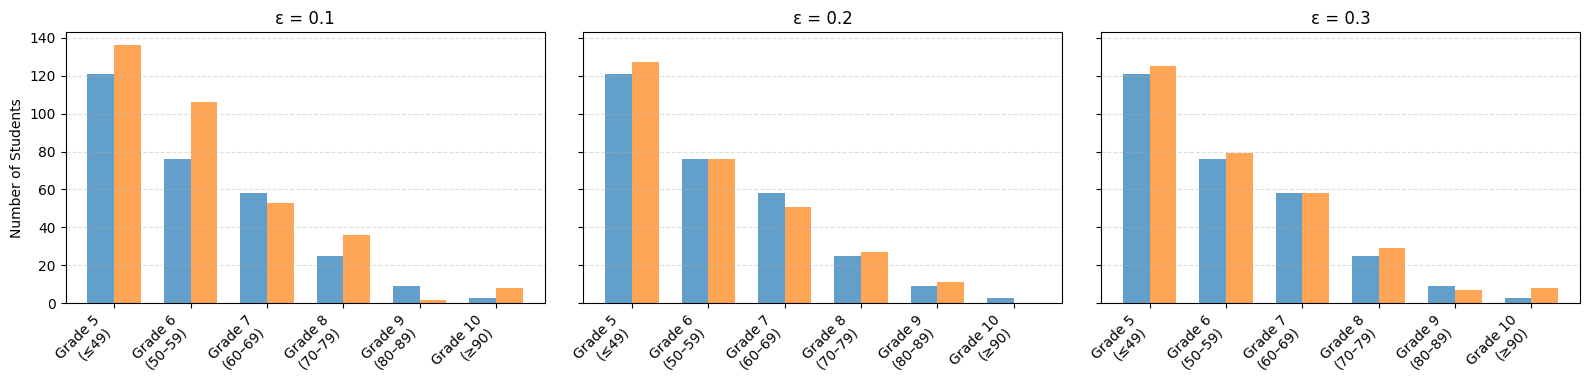

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0.1, 0.2, 0.3]

dp_counts_list = [dp_counts[round(eps, 2)] for eps in epsilons]

grade_labels = [
    "Grade 5\n(≤49)",
    "Grade 6\n(50–59)",
    "Grade 7\n(60–69)",
    "Grade 8\n(70–79)",
    "Grade 9\n(80–89)",
    "Grade 10\n(≥90)",
]


fig, axes = plt.subplots(
    nrows=1,
    ncols=len(epsilons),
    figsize=(16, 4),
    sharey=True
)

bar_width = 0.35
x = np.arange(len(grade_labels))

for ax, eps, noisy in zip(axes, epsilons, dp_counts_list):
    ax.bar(x - bar_width/2, orig_counts,
           width=bar_width, label="Original", alpha=0.7)
    ax.bar(x + bar_width/2, noisy,
           width=bar_width, label=f"DP (ε = {eps})", alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(grade_labels, rotation=45, ha="right")
    ax.set_title(f"ε = {eps}")
    if eps == epsilons[0]:
        ax.set_ylabel("Number of Students")
    ax.grid(axis="y", linestyle="--", alpha=0.4)


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from diffprivlib import tools
import pandas as pd

scores = df["Test_results"].to_numpy()
bins   = [0, 50, 60, 70, 80, 90, 101]
N      = len(scores)
epsilons  = [0.1, 0.2, 0.3,0.4,0.5]
runs      = 1_000
metrics   = {eps: {"mean_abs": 0, "max_abs": 0, "tv": 0} for eps in epsilons}

true_counts, _ = np.histogram(scores, bins=bins)

for eps in epsilons:
    abs_err, tv_dist = [], []
    for _ in range(runs):
        noisy, _ = tools.histogram(scores, bins=bins,
                                   epsilon=eps, range=(0, 101))
        diff = np.abs(noisy - true_counts)      # |Δ| per bin
        abs_err.append(diff)
        tv_dist.append(0.5 * diff.sum() / N)
    diff_mean = np.mean(abs_err, axis=0)
    metrics[eps]["mean_abs"] = diff_mean.mean()
    metrics[eps]["max_abs"]  = diff_mean.max()
    metrics[eps]["tv"]       = np.mean(tv_dist)

# Pretty-print
err_df = (pd.DataFrame(metrics)
            .T.rename(columns={"mean_abs":"mean|Δ|",
                               "max_abs":"max|Δ|",
                               "tv":"TV distance"}))
print(err_df.round(2))


     mean|Δ|  max|Δ|  TV distance
0.1     8.81    9.71         0.09
0.2     4.66    5.16         0.05
0.3     3.11    3.27         0.03
0.4     2.31    2.51         0.02
0.5     1.86    1.97         0.02


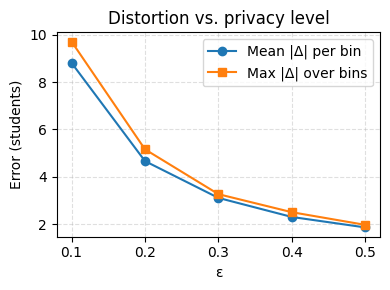

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(err_df.index, err_df["mean|Δ|"], marker="o", label="Mean |Δ| per bin")
plt.plot(err_df.index, err_df["max|Δ|"],  marker="s", label="Max |Δ| over bins")
plt.ylabel("Error (students)")
plt.xlabel("ε")
plt.title("Distortion vs. privacy level")
plt.grid(True, ls="--", alpha=.4)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
scores = df["Test_results"].to_numpy()
bins   = [0, 50, 60, 70, 80, 90, 101]
true_counts, _ = np.histogram(scores, bins=bins)
N = len(scores)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from diffprivlib import tools

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
delta    = 1 / N**2
runs     = 1_000

sensitivity = 1

def gaussian_mech(counts, eps, delta, sens=1):
    sigma = (sens / eps) * np.sqrt(2 * np.log(1.25 / delta))
    noise = np.random.normal(loc=0.0, scale=sigma, size=len(counts))
    noisy = counts + noise
    noisy = np.clip(np.round(noisy), 0, None).astype(int)
    return noisy

metrics = {
    "ε": [], "Mechanism": [],
    "mean|Δ|": [], "max|Δ|": [], "TV distance": []
}

for mech in ["Laplace", "Gaussian"]:
    for eps in epsilons:
        mean_abs, max_abs, tvs = [], [], []
        for _ in range(runs):
            if mech == "Laplace":
                noisy, _ = tools.histogram(
                    scores, bins=bins, epsilon=eps, range=(0, 101)
                )
            else:
                noisy = gaussian_mech(true_counts, eps, delta, sens=1)

            diff = np.abs(noisy - true_counts)
            mean_abs.append(diff.mean())
            max_abs.append(diff.max())
            tvs.append(0.5 * diff.sum() / N)

        metrics["ε"].append(eps)
        metrics["Mechanism"].append(mech)
        metrics["mean|Δ|"].append(np.mean(mean_abs))
        metrics["max|Δ|"].append(np.mean(max_abs))
        metrics["TV distance"].append(np.mean(tvs))

err_df = pd.DataFrame(metrics).set_index(["Mechanism", "ε"]).round(2)
print(err_df)

               mean|Δ|  max|Δ|  TV distance
Mechanism ε                                
Laplace   0.1     8.92   22.31         0.09
          0.2     4.66   11.59         0.05
          0.3     3.19    7.78         0.03
          0.4     2.39    5.89         0.02
          0.5     1.86    4.61         0.02
Gaussian  0.1    30.71   69.30         0.32
          0.2    16.62   36.39         0.17
          0.3    11.55   25.29         0.12
          0.4     8.78   18.49         0.09
          0.5     7.19   15.19         0.07


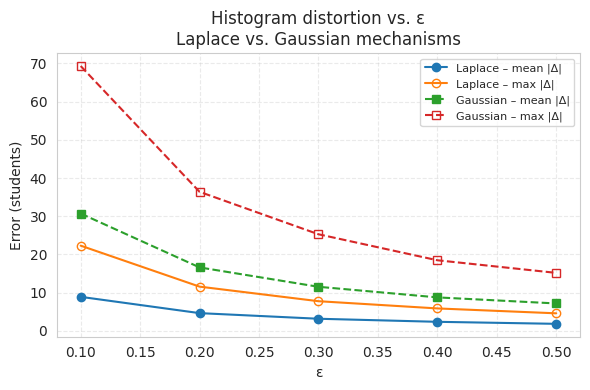

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

for mech, style in zip(["Laplace", "Gaussian"],
                       [("o", "-"), ("s", "--")]):
    eps_vals      = err_df.loc[mech].index.to_numpy()
    mean_err_vals = err_df.loc[mech]["mean|Δ|"].to_numpy()
    max_err_vals  = err_df.loc[mech]["max|Δ|"].to_numpy()

    ax.plot(eps_vals, mean_err_vals,
            style[1], marker=style[0],
            label=f"{mech} – mean |Δ|")
    ax.plot(eps_vals, max_err_vals,
            style[1], marker=style[0], mfc="none",
            label=f"{mech} – max |Δ|")

ax.set_xlabel("ε")
ax.set_ylabel("Error (students)")
ax.set_title("Histogram distortion vs. ε\nLaplace vs. Gaussian mechanisms")
ax.grid(True, ls="--", alpha=.4)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

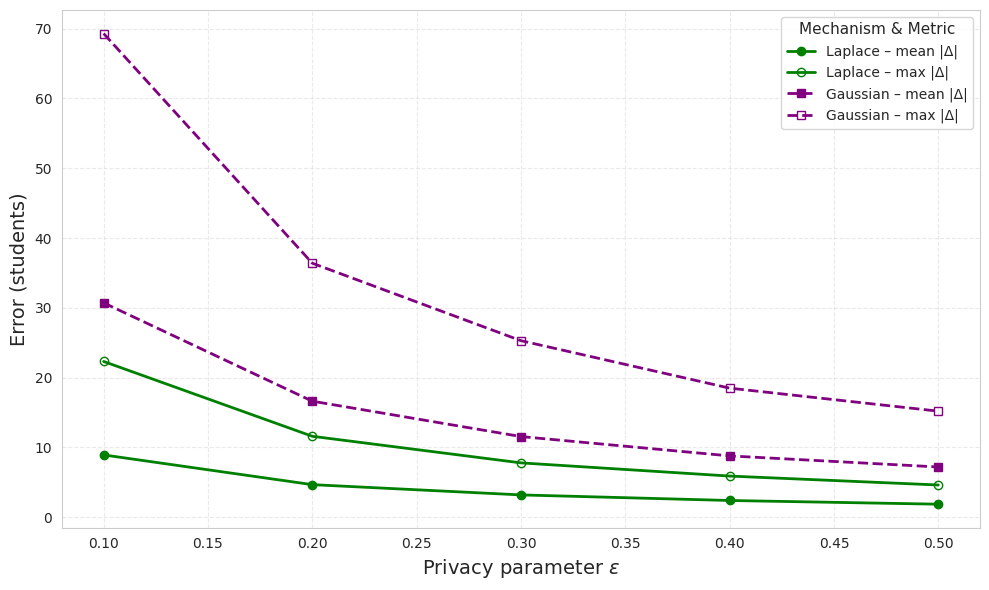

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

colors = {"Laplace": "green", "Gaussian": "purple"}
styles = {"Laplace": ("o", "-"), "Gaussian": ("s", "--")}

for mech in ["Laplace", "Gaussian"]:
    eps_vals = err_df.loc[mech].index.to_numpy()
    mean_err_vals = err_df.loc[mech]["mean|Δ|"].to_numpy()
    max_err_vals = err_df.loc[mech]["max|Δ|"].to_numpy()
    marker, linestyle = styles[mech]
    color = colors[mech]

    ax.plot(eps_vals, mean_err_vals, linestyle, marker=marker, color=color,
            label=f"{mech} – mean |Δ|", linewidth=2, markersize=6)
    ax.plot(eps_vals, max_err_vals, linestyle, marker=marker, color=color,
            label=f"{mech} – max |Δ|", linewidth=2, markersize=6, mfc="none")

ax.set_xlabel(r"Privacy parameter $\epsilon$", fontsize=14)
ax.set_ylabel(r"Error (students)", fontsize=14)
ax.legend(fontsize=10, title="Mechanism & Metric", title_fontsize=11)
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("fig-error-curves-overall.png", dpi=600)
plt.show()



=== Distortion metrics per program ===
        mean|Δ|             max|Δ|              TV distance            
ε           0.1   0.2   0.3    0.1    0.2   0.3         0.1   0.2   0.3
Program                                                                
KN         5.64  3.33  2.29  16.58   9.27  6.30        1.13  0.67  0.46
PIT        7.56  3.87  2.64  20.67  10.85  7.33        0.20  0.10  0.07
SIIS       8.79  4.65  3.18  22.06  11.41  7.73        0.16  0.08  0.06


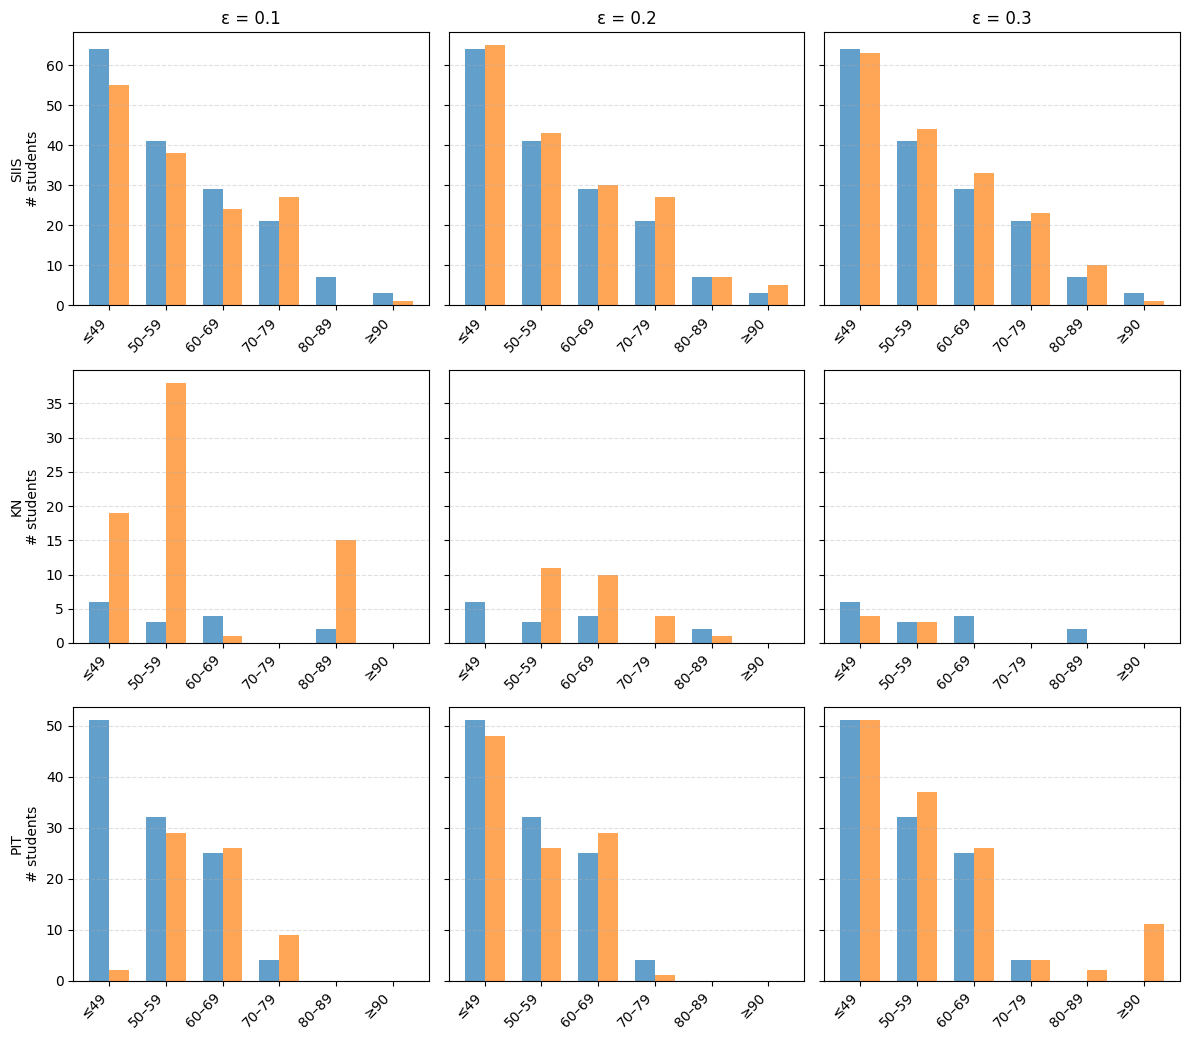

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from diffprivlib import tools


epsilons = [0.1, 0.2,0.3]
runs     = 500
bins     = [0, 50, 60, 70, 80, 90, 101]
grade_labels = [
    "≤49", "50–59", "60–69",
    "70–79", "80–89", "≥90"
]


programs = ["SIIS", "KN", "PIT"]
true_hist = {}
N_prog    = {}

for prog in programs:
    scores_p = df.loc[df["study_program"] == prog, "Test_results"]
    true_hist[prog], _ = np.histogram(scores_p, bins=bins)
    N_prog[prog] = len(scores_p)


dp_hist   = {eps: {} for eps in epsilons}

for eps in epsilons:
    for prog in programs:
        scores_p = df.loc[df["study_program"] == prog, "Test_results"]
        noisy, _ = tools.histogram(
            scores_p, bins=bins, epsilon=eps, range=(0, 101)
        )
        dp_hist[eps][prog] = noisy

metrics = {
    "Program": [], "ε": [],
    "mean|Δ|": [], "max|Δ|": [], "TV distance": []
}

for prog in programs:
    scores_p = df.loc[df["study_program"] == prog, "Test_results"].to_numpy()
    true_p, _ = np.histogram(scores_p, bins=bins)
    Np = len(scores_p)

    for eps in epsilons:
        mean_abs, max_abs, tvs = [], [], []
        for _ in range(runs):
            noisy, _ = tools.histogram(
                scores_p, bins=bins, epsilon=eps, range=(0, 101)
            )
            diff = np.abs(noisy - true_p)
            mean_abs.append(diff.mean())
            max_abs.append(diff.max())
            tvs.append(0.5 * diff.sum() / Np)

        metrics["Program"].append(prog)
        metrics["ε"].append(eps)
        metrics["mean|Δ|"].append(np.mean(mean_abs))
        metrics["max|Δ|"].append(np.mean(max_abs))
        metrics["TV distance"].append(np.mean(tvs))

err_df = pd.DataFrame(metrics).round(2)
print("\n=== Distortion metrics per program ===")
print(err_df.pivot(index="Program", columns="ε")[["mean|Δ|","max|Δ|","TV distance"]])


fig, axes = plt.subplots(
    nrows=len(programs), ncols=len(epsilons),
    figsize=(4 * len(epsilons), 3.5 * len(programs)),
    sharey='row'
)
bar_w = 0.35
x = np.arange(len(grade_labels))

for r, prog in enumerate(programs):
    for c, eps in enumerate(epsilons):
        ax = axes[r, c] if len(programs) > 1 else axes[c]
        orig = true_hist[prog]
        noisy = dp_hist[eps][prog]

        ax.bar(x - bar_w/2, orig,  width=bar_w, label="Original", alpha=0.7)
        ax.bar(x + bar_w/2, noisy, width=bar_w, label=f"DP ε={eps}", alpha=0.7)

        if r == 0:  ax.set_title(f"ε = {eps}")
        if c == 0:  ax.set_ylabel(f"{prog}\n# students")
        ax.set_xticks(x)
        ax.set_xticklabels(grade_labels, rotation=45, ha="right")
        ax.grid(axis="y", ls="--", alpha=.4)

plt.tight_layout()
plt.show()


max|Δ|                             mean|Δ|                \
ε                  0.10   0.15   0.20   0.25   0.30    0.10   0.15   0.20   
Program Mech                                                                
KN      Gaussian  61.90  39.46  31.25  24.59  20.19   20.30  13.67  11.18   
        Laplace   18.44  11.72   9.63   7.60   6.29    6.16   4.16   3.45   
PIT     Gaussian  61.86  43.53  34.61  29.06  23.86   24.50  18.11  14.50   
        Laplace   20.85  14.79  10.74   8.87   7.00    7.50   5.27   3.91   
SIIS    Gaussian  66.11  45.62  35.82  28.18  24.99   28.65  20.24  16.09   
        Laplace   21.92  14.84  11.54   9.12   7.51    8.68   5.97   4.64   

                                
ε                  0.25   0.30  
Program Mech                    
KN      Gaussian   8.85   7.46  
        Laplace    2.81   2.36  
PIT     Gaussian  11.85   9.71  
        Laplace    3.24   2.59  
SIIS    Gaussian  13.04  11.56  
        Laplace    3.73   3.09

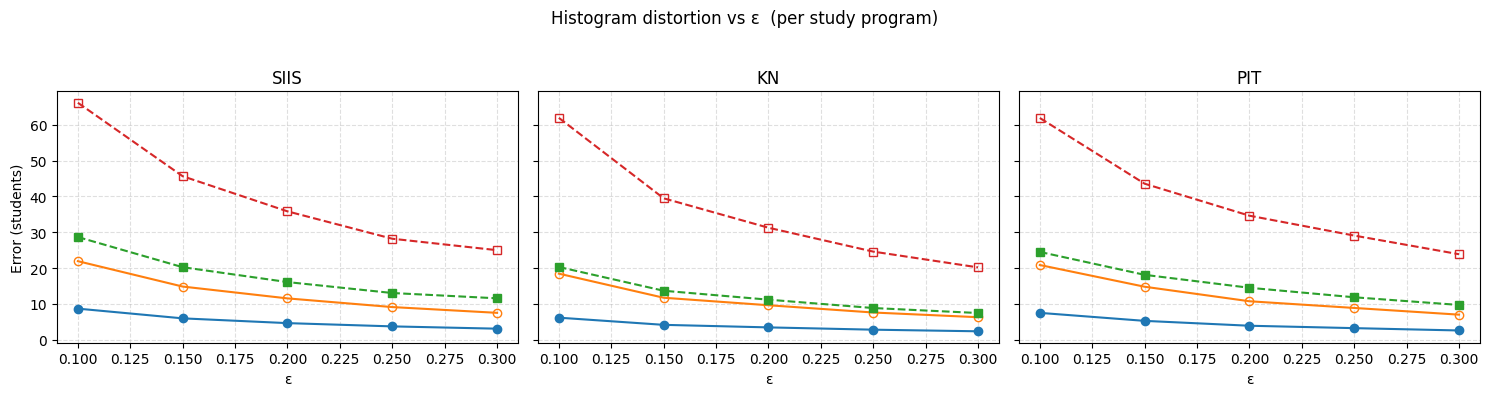

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from diffprivlib import tools

epsilons = [0.1,0.15,0.2,0.25, 0.3]
runs     = 500
bins     = [0, 50, 60, 70, 80, 90, 101]
programs = ["SIIS", "KN", "PIT"]
delta    = 1e-5

def gaussian_hist(counts, eps, delta):
    sens  = 1
    sigma = sens / eps * np.sqrt(2*np.log(1.25/delta))
    noise = np.random.normal(0.0, sigma, size=len(counts))
    return np.clip(np.round(counts + noise), 0, None).astype(int)

true_hist, N_prog = {}, {}
for prog in programs:
    s   = df.loc[df.study_program==prog, "Test_results"].to_numpy()
    true_hist[prog], _ = np.histogram(s, bins=bins)
    N_prog[prog] = len(s)

rows = []
for prog in programs:
    counts_true = true_hist[prog]
    n = N_prog[prog]

    for eps in epsilons:
        for mech in ["Laplace", "Gaussian"]:
            mean_abs, max_abs, tvs = [], [], []
            for _ in range(runs):
                if mech == "Laplace":
                    noisy, _ = tools.histogram(
                        df.loc[df.study_program==prog,"Test_results"],
                        bins=bins, epsilon=eps, range=(0,101)
                    )
                else:   # Gaussian
                    noisy = gaussian_hist(counts_true, eps, delta)

                diff = np.abs(noisy - counts_true)
                mean_abs.append(diff.mean())
                max_abs.append(diff.max())
                tvs.append(0.5 * diff.sum() / n)

            rows.append({
                "Program": prog, "ε": eps, "Mech": mech,
                "mean|Δ|": np.mean(mean_abs),
                "max|Δ|" : np.mean(max_abs),
                "TV"     : np.mean(tvs)
            })

err_df = pd.DataFrame(rows).round(2)

# quick sanity print
display(err_df.pivot_table(index=["Program","Mech"], columns="ε",
                           values=["mean|Δ|","max|Δ|"]))


markers = {"Laplace":"o", "Gaussian":"s"}
lines   = {"Laplace":"-", "Gaussian":"--"}
fig, axes = plt.subplots(1, len(programs), figsize=(15,4), sharey=True)

for ax, prog in zip(axes, programs):
    sub = err_df[err_df.Program==prog]
    for mech in ["Laplace","Gaussian"]:
        dm = sub[sub.Mech==mech].set_index("ε")
        ax.plot(dm.index, dm["mean|Δ|"],
                lines[mech], marker=markers[mech],
                label=f"{mech} – mean Δ")
        ax.plot(dm.index, dm["max|Δ|"],
                lines[mech], marker=markers[mech], mfc="none",
                label=f"{mech} – max Δ")

    ax.set_title(prog)
    ax.set_xlabel("ε")
    ax.grid(True, ls="--", alpha=.4)
axes[0].set_ylabel("Error (students)")
fig.suptitle("Histogram distortion vs ε  (per study program)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


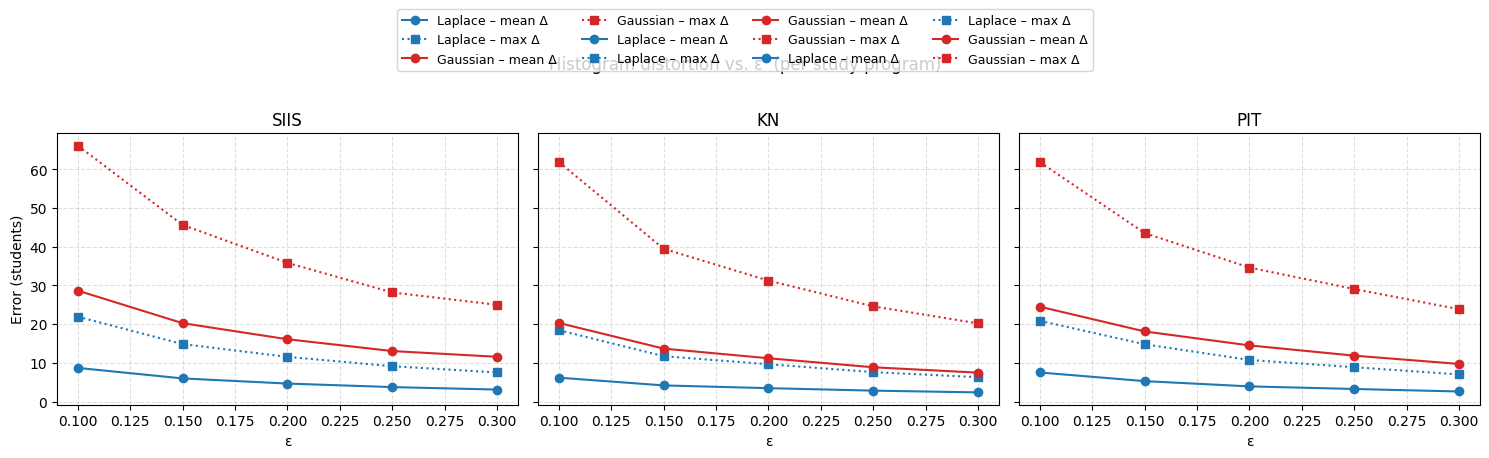

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import cycler


err_df_sorted = err_df.sort_values("ε")

colour_map = {"Laplace": "#1f77b4", "Gaussian": "#d62728"}

fig, axes = plt.subplots(1, len(programs), figsize=(15, 4), sharey=True)

for ax, prog in zip(axes, programs):
    sub = err_df_sorted[err_df_sorted.Program == prog]

    for mech in ["Laplace", "Gaussian"]:
        dm = (sub[sub.Mech == mech]
              .set_index("ε")
              .sort_index())

        ax.plot(dm.index, dm["mean|Δ|"],
                marker="o", linestyle="-", color=colour_map[mech],
                label=f"{mech} – mean Δ")

        ax.plot(dm.index, dm["max|Δ|"],
                marker="s", linestyle=":", color=colour_map[mech],
                label=f"{mech} – max Δ")

    ax.set_title(prog)
    ax.set_xlabel("ε")
    ax.grid(ls="--", alpha=.4)

axes[0].set_ylabel("Error (students)")
fig.suptitle("Histogram distortion vs. ε  (per study program)", y=1.02)
fig.legend(loc="upper center", ncol=4, fontsize=9, bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.show()


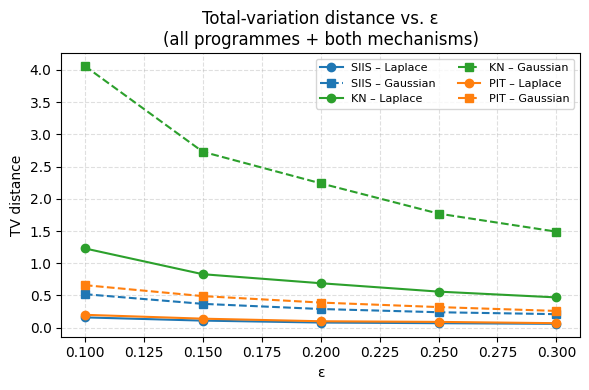

In [ ]:
import matplotlib.pyplot as plt

prog_colour = {"SIIS": "#1f77b4", "KN": "#2ca02c", "PIT": "#ff7f0e"}
mech_style  = {"Laplace": ("o", "-"), "Gaussian": ("s", "--")}

fig, ax = plt.subplots(figsize=(6, 4))

for prog in programs:
    sub = err_df[err_df.Program == prog]
    for mech in ["Laplace", "Gaussian"]:
        dm = (sub[sub.Mech == mech]
               .set_index("ε")
               .sort_index())
        marker, lstyle = mech_style[mech]
        ax.plot(dm.index, dm["TV"],
                linestyle=lstyle, marker=marker,
                color=prog_colour[prog],
                label=f"{prog} – {mech}")

ax.set_xlabel("ε")
ax.set_ylabel("TV distance")
ax.set_title("Total-variation distance vs. ε\n(all programmes + both mechanisms)")
ax.grid(ls="--", alpha=.4)
ax.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()
